# Setup

Import libraries

In [53]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import truncnorm, truncexpon
import math

from network0_def import *
from network1_config import *

from network2_clustersize import *
from network2_si import *
from network3_klist import *





Set up 2 configuration model networks for the entire experiments:
1. Poisson degree distribution
2. Geometric degree distribution

In [2]:
# parameters
n = 4069
k_mean = 10 # mean degree

network_p = config_graph_gen(n, deg_dist_poisson(n, k_mean))
network_g = config_graph_gen(n, deg_dist_geo(n, k_mean))

In [ ]:
# # parameters
# n = 10000
# k_mean = 20 # mean degree

# network_p = config_graph_gen(n, deg_dist_poisson(n, k_mean))
# network_g = config_graph_gen(n, deg_dist_geo(n, k_mean))

In [ ]:
# Plot the degree distribution
plt.figure()
degs_p = network_p.deg_dist()
degs_g = network_g.deg_dist()
plt.hist(degs_p, bins=np.arange(np.max(degs_p))-0.5, density=True, alpha=0.5, label='Poisson')
plt.hist(degs_g, bins=np.arange(np.max(degs_g))-0.5, density=True, alpha=0.5, label='Geometric')
plt.xlabel('Degree')
plt.ylabel('Probability density function (i.e. normalized frequency)')
plt.legend()
plt.show()

In [3]:
edge_ls_p = network_p.edge_list()
edge_ls_g = network_g.edge_list()

# Single deterministic $\lambda$

Set up disease parameters.

In [15]:
# lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])
lambda_means = np.array([0.0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5])



In [16]:
c_p_undirec0 = np.zeros(len(lambda_means))
c_g_undirec0 = np.zeros(len(lambda_means))

for idx,lambda_ in enumerate(lambda_means):
    c_p_undirec0[idx] = SIR_djset(n, edge_ls_p, lambda_)
    c_g_undirec0[idx] = SIR_djset(n, edge_ls_g, lambda_)
    print("lambda = ", lambda_, "c_p = ", c_p_undirec0[idx], "c_g = ", c_g_undirec0[idx])

lambda =  0.0 c_p =  1.0 c_g =  1.0
lambda =  0.025 c_p =  1.333742934381912 c_g =  1.4802162693536496
lambda =  0.05 c_p =  2.0597198328827724 c_g =  8.28729417547309
lambda =  0.075 c_p =  3.5475546817399852 c_g =  227.3627426886213
lambda =  0.1 c_p =  20.36937822560826 c_g =  594.3885475546817
lambda =  0.15 c_p =  1403.6537232735316 c_g =  1212.8387810272795
lambda =  0.2 c_p =  2575.479233226837 c_g =  1655.3568444335217
lambda =  0.25 c_p =  3315.6650282624723 c_g =  2007.7333497173752
lambda =  0.3 c_p =  3642.8505775374783 c_g =  2212.1260752027524
lambda =  0.4 c_p =  3898.839272548538 c_g =  2549.9461784222167
lambda =  0.5 c_p =  4021.1479478987467 c_g =  2781.325387072991


Run simulations using k-list algorithm

In [17]:
def config_graph_edge_ls(n, k_ary):
    """Generate a configuration model edge list with n nodes and degree array k_ary."""
    edge_ls = np.array([i for i in range(n) for _ in range(k_ary[i])])
    edge_ls = np.random.permutation(edge_ls)
    if len(edge_ls) % 2 == 1:
        edge_ls = edge_ls[:-1]

    # edge_ls gives list of edges, with each row representing the index of the two nodes connected by the edge
    edge_ls = edge_ls.reshape(-1, 2)
    return edge_ls

In [18]:

mu_p = np.zeros(len(lambda_means)) # Mean of the number of total infections mu over lambda
mu_g = np.zeros(len(lambda_means)) 
cov_p = np.zeros(len(lambda_means)) # coefficient of variation of the number of total infections sigma / mu over lambda
cov_g = np.zeros(len(lambda_means))

edge_ls_p = config_graph_edge_ls(n, deg_dist_poisson(n, k_mean))
edge_ls_g = config_graph_edge_ls(n, deg_dist_geo(n, k_mean))

# Run for one iteration only, take result for first node only (for avg_n=1 )
output_p= SIR_ci_lambda(n, edge_ls_p, lambda_means, 1000, False) # output shape (lam_n, avg_n)
output_g= SIR_ci_lambda(n, edge_ls_g, lambda_means, 1000, False) # output shape (lam_n, avg_n)
print("output matrix p:", output_p) 
print("output matrix g:", output_g)
# Compute mean and coefficient of variation over all avg_n nodes
mu_p = np.mean(output_p, axis=1)        # shape (lam_n,)
cov_p = np.std(output_p, axis=1) / mu_p   # shape (lam_n,)
mu_g = np.mean(output_g, axis=1)        # shape (lam_n,)
cov_g = np.std(output_g, axis=1) / mu_g   # shape (lam_n,)

print("mu:", mu_p)
print("cov:", cov_p)
print("mu:", mu_g)
print("cov:", cov_g)


shape of bino coeff: (11, 20128)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape of ci_k: (20128, 1000)
shape of all ci_lambda (not averaged): (11, 1000)
shape of bino coeff: (11, 20399)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape of ci_k: (20399, 1000)
shape of all ci_lambda (not averaged): (11, 1000)
output matrix p: [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [9.99999999e-01 2.00000000e+00 9.99999999e-01 ... 2.00000000e+00
  9.99999999e-01 2.00000000e+00]
 [9.99999996e-01 1.99999999e+00 9.99999996e-01 ... 1.99999999e+00
  9.99999996e-01 1.99999999e+00]
 ...
 [3.82113648e+03 3.82113648e+03 1.00000000e+00 ... 3.82113648e+03
  3.82113648e+03 3.82113648e+03]
 [3.97243074e+03 3.97243074e+03 3.97243074e+03

In [20]:
print("mu:", mu_p)
print("cov:", cov_p)
print("mu:", mu_g)
print("cov:", cov_g)

mu: [1.00000000e+00 1.30995814e+00 1.94569133e+00 3.35309959e+00
 8.02840775e+00 1.27616071e+03 2.58812266e+03 3.20623869e+03
 3.60217518e+03 3.88242883e+03 3.99283083e+03]
cov: [0.         0.57859482 0.87389895 1.14805277 1.48705519 0.84996082
 0.48409111 0.35037808 0.24474128 0.15070707 0.10539418]
mu: [1.00000000e+00 1.43792019e+00 4.43399686e+00 1.71907773e+02
 5.76295209e+02 1.13830966e+03 1.62702380e+03 1.94943415e+03
 2.20587902e+03 2.62662085e+03 2.86774411e+03]
cov: [0.         0.86567657 2.55537725 1.96839811 1.29361846 0.96038216
 0.77080934 0.66860908 0.60634719 0.49593289 0.43819473]


In [ ]:
# mu: [1.00000000e+00 1.30995814e+00 1.94569133e+00 3.35309959e+00
#  8.02840775e+00 1.27616071e+03 2.58812266e+03 3.20623869e+03
#  3.60217518e+03 3.88242883e+03 3.99283083e+03]
# cov: [0.         0.57859482 0.87389895 1.14805277 1.48705519 0.84996082
#  0.48409111 0.35037808 0.24474128 0.15070707 0.10539418]
# mu: [1.00000000e+00 1.43792019e+00 4.43399686e+00 1.71907773e+02
#  5.76295209e+02 1.13830966e+03 1.62702380e+03 1.94943415e+03
#  2.20587902e+03 2.62662085e+03 2.86774411e+03]
# cov: [0.         0.86567657 2.55537725 1.96839811 1.29361846 0.96038216
#  0.77080934 0.66860908 0.60634719 0.49593289 0.43819473]

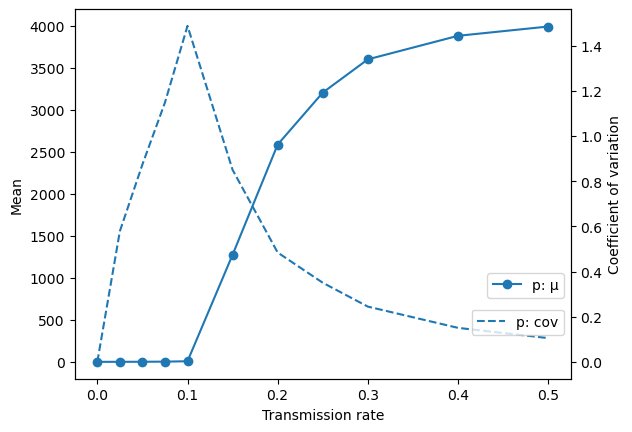

In [52]:
# Plot data on the first y-axis
fig, ax1 = plt.subplots()
ax1.plot(lambda_means, mu_p, "o-", color = 'tab:blue', label="p: μ")
ax1.set_xscale('linear')
ax1.set_xlabel('Transmission rate')
ax1.set_ylabel("Mean")
ax1.tick_params(axis='y')
ax1.set_ylim([-200, 4200])

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(lambda_means, cov_p, "--", color = 'tab:blue', label="p: cov")
ax2.set_xscale('linear')
ax2.set_ylabel("Coefficient of variation")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(loc='lower right', bbox_to_anchor=(1.0, 0.2))
ax2.legend(loc='lower right', bbox_to_anchor=(1.0, 0.1))
# Show the plot
plt.show()


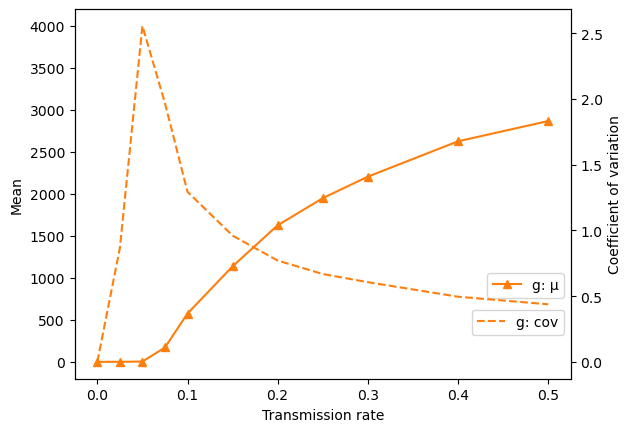

In [51]:
# Plot data on the first y-axis
fig, ax1 = plt.subplots()
ax1.plot(lambda_means, mu_g, "^-", color = 'tab:orange', label="g: μ")
ax1.set_xscale('linear')
ax1.set_xlabel('Transmission rate')
ax1.set_ylabel("Mean")
ax1.tick_params(axis='y')
ax1.set_ylim([-200, 4200])

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(lambda_means, cov_g, "--", color = 'tab:orange', label="g: cov")
ax2.set_xscale('linear')
ax2.set_ylabel("Coefficient of variation")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(loc='lower right', bbox_to_anchor=(1.0, 0.2))
ax2.legend(loc='lower right', bbox_to_anchor=(1.0, 0.1))
# Show the plot
plt.show()

# Theoretical s values

In [35]:
s_ary_p = np.zeros(len(lambda_means))
s_ary_g = np.zeros(len(lambda_means))
for idx, lambda_ in enumerate(lambda_means):

    s_p = compute_s_prob(network_p, lambda_)
    s_ary_p[idx] = np.average(s_p)
    print(f"Poisson: lambda = {lambda_}, s = {np.average(s_p)}")

    s_g = compute_s_prob(network_g, lambda_)
    s_ary_g[idx] = np.average(s_g)
    print(f"Geometric: lambda = {lambda_}, s = {np.average(s_g)}")


Nr_ary_ps = n * (1 - s_ary_p)
Nr_ary_gs = n * (1 - s_ary_g)
print(f"pred_p:{Nr_ary_ps}")
print(f"pred_g:{Nr_ary_gs}")


Poisson: lambda = 0.0, s = 1.0
Geometric: lambda = 0.0, s = 1.0
Poisson: lambda = 0.025, s = 0.9999988748921761
Geometric: lambda = 0.025, s = 0.9999990159977041
Poisson: lambda = 0.05, s = 0.9999949975890691
Geometric: lambda = 0.05, s = 0.9839063252968542
Poisson: lambda = 0.075, s = 0.9999796133723433
Geometric: lambda = 0.075, s = 0.75741666969244
Poisson: lambda = 0.1, s = 0.8229022650656949
Geometric: lambda = 0.1, s = 0.6218536993548108
Poisson: lambda = 0.15, s = 0.3630941756979418
Geometric: lambda = 0.15, s = 0.46392592631293667
Poisson: lambda = 0.2, s = 0.18311534378879865
Geometric: lambda = 0.2, s = 0.3732885902730881
Poisson: lambda = 0.25, s = 0.09939088353708808
Geometric: lambda = 0.25, s = 0.3138562212061769
Poisson: lambda = 0.3, s = 0.056419417253560276
Geometric: lambda = 0.3, s = 0.2715571277990361
Poisson: lambda = 0.4, s = 0.019737410635565257
Geometric: lambda = 0.4, s = 0.2147854530930385
Poisson: lambda = 0.5, s = 0.007488557155784562
Geometric: lambda = 0.5

In [36]:
# Compute critical lambda
lambda_crit_p = crit_lambda(network_p)
lambda_crit_g = crit_lambda(network_g)
print(f"crit_p: {lambda_crit_p}"
        f"crit_g: {lambda_crit_g}")

crit_p: 0.08972255459906701crit_g: 0.04870343020404207


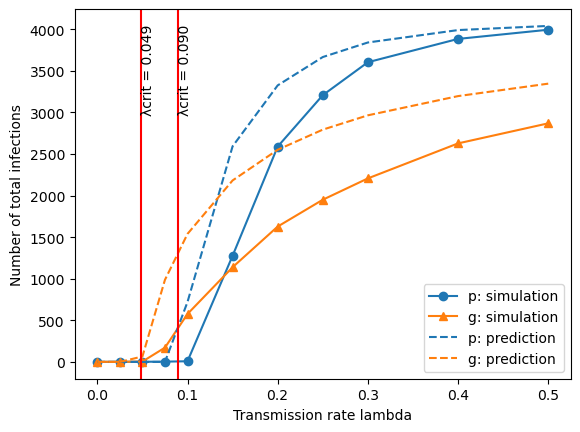

In [45]:
# plot simulation with theoretical critical lambda
plt.figure()
plt.plot(lambda_means, mu_p, "o-", color = 'tab:blue', label="p: simulation")
plt.plot(lambda_means, mu_g, "^-", color = 'tab:orange', label="g: simulation")

plt.plot(lambda_means, Nr_ary_ps, linestyle = "--", color = 'tab:blue', label="p: prediction")
plt.plot(lambda_means, Nr_ary_gs, linestyle = "--", color = 'tab:orange', label="g: prediction")
plt.axvline(x=lambda_crit_p, color='r')
plt.text(lambda_crit_p, 3000, f'λcrit = {lambda_crit_p:.3f}', rotation=90) 
                                            
plt.axvline(x=lambda_crit_g, color='r')
plt.text(lambda_crit_g, 3000, f'λcrit = {lambda_crit_g:.3f}', rotation=90)

plt.xlabel("Transmission rate lambda")
plt.ylabel("Number of total infections")
plt.legend()
plt.show()


# Distributions of $\lambda_i$ for individual nodes

In [63]:
dists = [None, "uniform", "normal"]

Generation of $\lambda_i$ arrays for each given $\lambda$ mean.

In [64]:
def node_lambda(n, mean, dist=None):
    """Generate the susceptibility for each node in the network."""
    # variance scale with mean value !!!!!

    if mean == 0:
        return np.zeros(n)
    
    if dist is None:
        lambda_i = np.full(n, mean)
    elif dist == "uniform":
        lambda_i = np.random.uniform(0, 2*mean, n)
    elif dist == "normal":
        std = mean / 3
        a=0
        b=2*mean
        a_norm, b_norm = (a - mean) / std, (b - mean) / std
        lambda_i = truncnorm(a=a_norm, b=b_norm, loc=mean, scale=std).rvs(n)

    elif dist == "exponential":
        scale = mean
        b = 1/scale
        lambda_i = truncexpon(b=b, loc=0, scale=scale).rvs(n)

    else:
        raise ValueError("Invalid distribution type.")
    return lambda_i

def lambda_mat_gen(n, means, dist=None):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda mean."""
    lambda_mat = np.empty((len(means),n))
    for idx, mean in enumerate(means):
        lambda_i = node_lambda(n, mean, dist)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(means), n)


Set up experiments

In [82]:
lambda_mats = np.empty((len(dists), len(lambda_means), n))
for idx, dist in enumerate(dists):
    lambda_mats[idx] = lambda_mat_gen(n, lambda_means, dist) # shape (len(lambda_means), n)

print(np.shape(lambda_mats))

(3, 11, 4069)


In [66]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mats, axis=2)
print(lambda_means_actual)

[[0.         0.025      0.05       0.075      0.1        0.15
  0.2        0.25       0.3        0.4        0.5       ]
 [0.         0.02511691 0.05039779 0.07515057 0.10104128 0.14852075
  0.19908792 0.24866853 0.29821438 0.39603447 0.49999928]
 [0.         0.02496595 0.04988837 0.07520183 0.09971175 0.15030025
  0.19931472 0.24981693 0.29893387 0.39953025 0.49958506]]


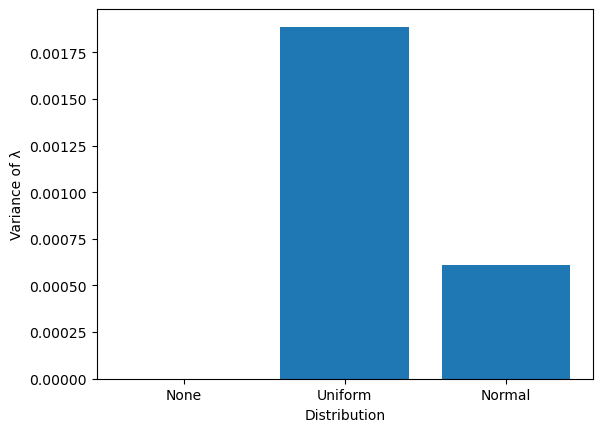

In [85]:
# check variance of each distribution
lambda_var = np.var(lambda_mats, axis=2)
plt.figure()
dists_str = ["None", "Uniform", "Normal"]
plt.bar(dists_str, lambda_var[:,3])
plt.xlabel('Distribution')
plt.ylabel('Variance of λ')
plt.show()

Visualising Lambda distribution with $\lambda = 0.025$

[0.1        0.10104128 0.09971175]


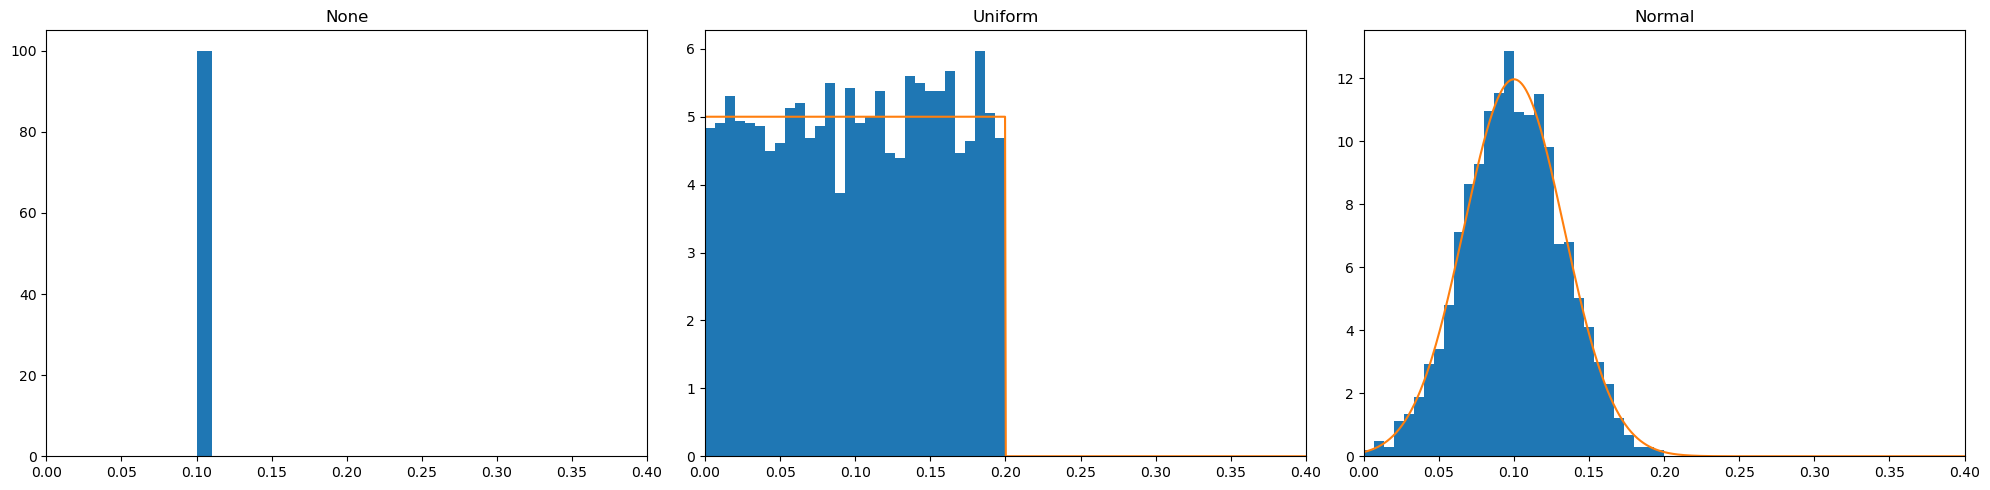

In [78]:
from scipy.stats import uniform, norm, expon

idx = 4 # for \lambda = 0.05
print(lambda_means_actual[:,idx])
# generate theoretical pdf plots for each distribution
x = np.linspace(0, 0.4, 800)
y_uniform= uniform.pdf(x, 0, 2*lambda_means[idx])
y_normal = norm.pdf(x, lambda_means[idx], lambda_means[idx]/3)
y_exp = expon.pdf(x, scale=lambda_means[idx])



# Create 1x4 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot each histogram in its respective subplot
axes[0].hist(lambda_mats[0, idx, :], bins=100, density =True, label = 'None')
axes[0].set_title('None')
axes[0].set_xlim([0, 0.4])

axes[1].hist(lambda_mats[1, idx, :], bins=30, density =True, label = 'Uniform')
axes[1].set_title('Uniform')
axes[1].plot(x, y_uniform, '-')
axes[1].set_xlim([0, 0.4])

axes[2].hist(lambda_mats[2, idx, :], bins=30, density =True, label = 'Normal')
axes[2].set_title('Normal')
axes[2].plot(x, y_normal, '-')
axes[2].set_xlim([0, 0.4])

# axes[3].hist(lambda_mats[3, idx, :], bins=30, density =True, label = 'Exponential')
# axes[3].set_title('Exponential')
# axes[3].plot(x, y_exp, '-')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Empiricals simulations:

In [142]:

output_c_p = np.zeros((len(dists), len(lambda_means)))
output_c_g = np.zeros((len(dists), len(lambda_means)))


for idx1, dist in enumerate(dists): # iterate over different distributions
    print("processing dist: ", dist, "\r")
    if dist is None:
        for idx2, lambda_ in enumerate(lambda_means):
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2] = SIR_djset(n, edge_ls_p, lambda_)
            output_c_g[idx1, idx2] = SIR_djset(n, edge_ls_g, lambda_)
            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")
            
    else:
        lambda_mat = lambda_mats[idx1] # shape (len(lambda_means), n)
        for idx2, lambdas in enumerate(lambda_mat): # iterate over different lambda mean values
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2] = SIR_djset_dir(n, edge_ls_p, lambdas, iter_n=1000)
            output_c_g[idx1, idx2] = SIR_djset_dir(n, edge_ls_g, lambdas, iter_n=1000)

            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")

processing dist:  None 
processing lambda:  0.0 
Dist = None, lambda_mean = 0.0, output_p = 1.0, output_g = 1.0
processing lambda:  0.025 
Dist = None, lambda_mean = 0.025, output_p = 1.3376751044482673, output_g = 1.4055050380928975
processing lambda:  0.05 
Dist = None, lambda_mean = 0.05, output_p = 1.8994839026787909, output_g = 4.301056770705333
processing lambda:  0.075 
Dist = None, lambda_mean = 0.075, output_p = 3.19120176947653, output_g = 257.9781273040059
processing lambda:  0.1 
Dist = None, lambda_mean = 0.1, output_p = 36.221430326861636, output_g = 646.6180879823053
processing lambda:  0.15 
Dist = None, lambda_mean = 0.15, output_p = 1323.75792578029, output_g = 1260.2150405505038
processing lambda:  0.2 
Dist = None, lambda_mean = 0.2, output_p = 2564.334480216269, output_g = 1704.1698205947407
processing lambda:  0.25 
Dist = None, lambda_mean = 0.25, output_p = 3261.7402310149914, output_g = 2004.9203735561564
processing lambda:  0.3 
Dist = None, lambda_mean = 0.3,

In [143]:
print(output_c_p)
print(output_c_g)

[[1.00000000e+00 1.33767510e+00 1.89948390e+00 3.19120177e+00
  3.62214303e+01 1.32375793e+03 2.56433448e+03 3.26174023e+03
  3.57318285e+03 3.90471541e+03 4.02313566e+03]
 [1.00000000e+00 1.38100000e+00 1.79100000e+00 3.57100000e+00
  1.72000000e+01 1.01479600e+03 2.07259300e+03 2.60039400e+03
  3.04004600e+03 3.41018200e+03 3.55013200e+03]
 [1.00000000e+00 1.33300000e+00 1.93400000e+00 3.36900000e+00
  2.07020000e+01 1.25849600e+03 2.45142400e+03 3.01107500e+03
  3.48039600e+03 3.80629000e+03 3.91237800e+03]]
[[1.00000000e+00 1.40550504e+00 4.30105677e+00 2.57978127e+02
  6.46618088e+02 1.26021504e+03 1.70416982e+03 2.00492037e+03
  2.23281568e+03 2.61846228e+03 2.83114451e+03]
 [1.00000000e+00 1.62400000e+00 8.07200000e+00 2.18518000e+02
  4.62019000e+02 1.02844000e+03 1.36380600e+03 1.65071400e+03
  1.95999400e+03 2.24558100e+03 2.51222400e+03]
 [1.00000000e+00 1.36600000e+00 7.95300000e+00 1.89526000e+02
  5.36381000e+02 1.14237800e+03 1.53316500e+03 1.94568500e+03
  2.13531800e+0

In [ ]:
[[1.00000000e+00 1.33767510e+00 1.89948390e+00 3.19120177e+00
  3.62214303e+01 1.32375793e+03 2.56433448e+03 3.26174023e+03
  3.57318285e+03 3.90471541e+03 4.02313566e+03]
 [1.00000000e+00 1.38100000e+00 1.79100000e+00 3.57100000e+00
  1.72000000e+01 1.01479600e+03 2.07259300e+03 2.60039400e+03
  3.04004600e+03 3.41018200e+03 3.55013200e+03]
 [1.00000000e+00 1.33300000e+00 1.93400000e+00 3.36900000e+00
  2.07020000e+01 1.25849600e+03 2.45142400e+03 3.01107500e+03
  3.48039600e+03 3.80629000e+03 3.91237800e+03]]
[[1.00000000e+00 1.40550504e+00 4.30105677e+00 2.57978127e+02
  6.46618088e+02 1.26021504e+03 1.70416982e+03 2.00492037e+03
  2.23281568e+03 2.61846228e+03 2.83114451e+03]
 [1.00000000e+00 1.62400000e+00 8.07200000e+00 2.18518000e+02
  4.62019000e+02 1.02844000e+03 1.36380600e+03 1.65071400e+03
  1.95999400e+03 2.24558100e+03 2.51222400e+03]
 [1.00000000e+00 1.36600000e+00 7.95300000e+00 1.89526000e+02
  5.36381000e+02 1.14237800e+03 1.53316500e+03 1.94568500e+03
  2.13531800e+03 2.49512000e+03 2.79071900e+03]]

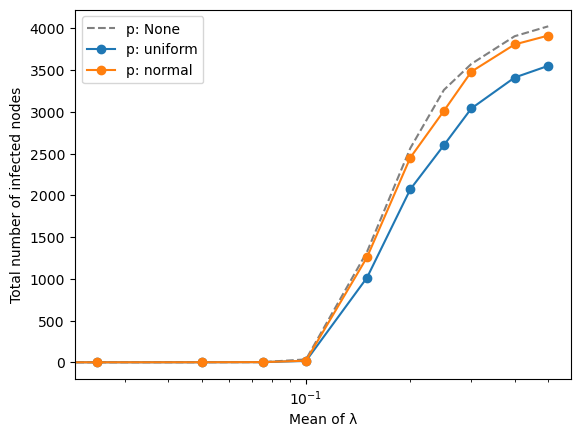

In [144]:
# plot poisson

plt.figure()

plt.plot(lambda_means, output_c_p[0], '--', label='p: None', color='grey')
plt.plot(lambda_means, output_c_p[1], 'o-', label='p: uniform', color='tab:blue')
plt.plot(lambda_means, output_c_p[2], 'o-', label='p: normal', color='tab:orange')


plt.xlabel('Mean of λ')
plt.xscale('log')
plt.ylabel('Total number of infected nodes')
plt.legend()
plt.show()

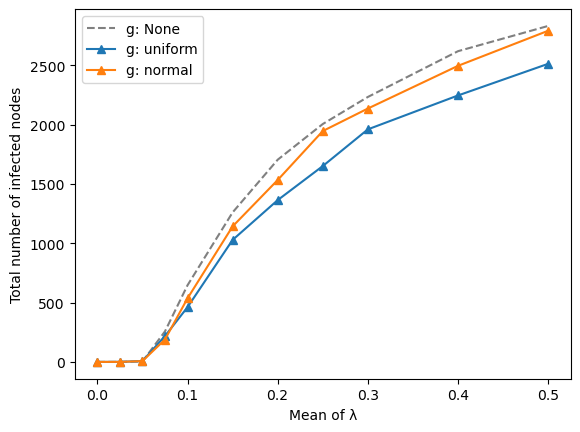

In [158]:
# plot geometric

plt.figure()

plt.plot(lambda_means, output_c_g[0], '--', label='g: None', color='grey')
plt.plot(lambda_means, output_c_g[1], '^-', label='g: uniform', color='tab:blue')
plt.plot(lambda_means, output_c_g[2], '^-', label='g: normal', color='tab:orange')


plt.xlabel('Mean of λ')
plt.ylabel('Total number of infected nodes')
plt.legend()
plt.show()

# Variance of $\lambda_i$ with normal distribution at mean = 0.5

In [146]:
# investigate how variance of a normally distributed lambda affects the number of infections

def node_lambda_nvar(n, mean, std):
    """Generate the susceptibility for each node in the network.
    lambda follows a normal distribution with given mean and std."""

    if std == 0:
        lambda_i = np.full(n, mean)
        return lambda_i
    else:
        a = 0
        b = 2*mean
        a_norm = (a - mean) / std
        b_norm = (b - mean) / std
        lambda_i = truncnorm(a=a_norm, b=b_norm, loc=mean, scale=std).rvs(n)
        return lambda_i


def lambda_mat_gen_nvar(n, mean, stds):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda variance, with the same value of lambda mean."""
    lambda_mat = np.empty((len(stds),n))
    for idx, std in enumerate(stds):
        lambda_i = node_lambda_nvar(n, mean, std)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(stds), n)

Set up experiments

In [147]:
lambda_mean = 0.5
lambda_stds = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.125, 0.15, 0.2])

In [148]:
lambda_mat_nvar = lambda_mat_gen_nvar(n, lambda_mean, lambda_stds) # shape (len(lambda_stds), n) for a single value of lambda_mean 

In [149]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mat_nvar, axis=1)
print(lambda_means_actual)

[0.5        0.49989233 0.50047351 0.49902602 0.50219185 0.49789017
 0.4991409  0.50081283 0.50239266]


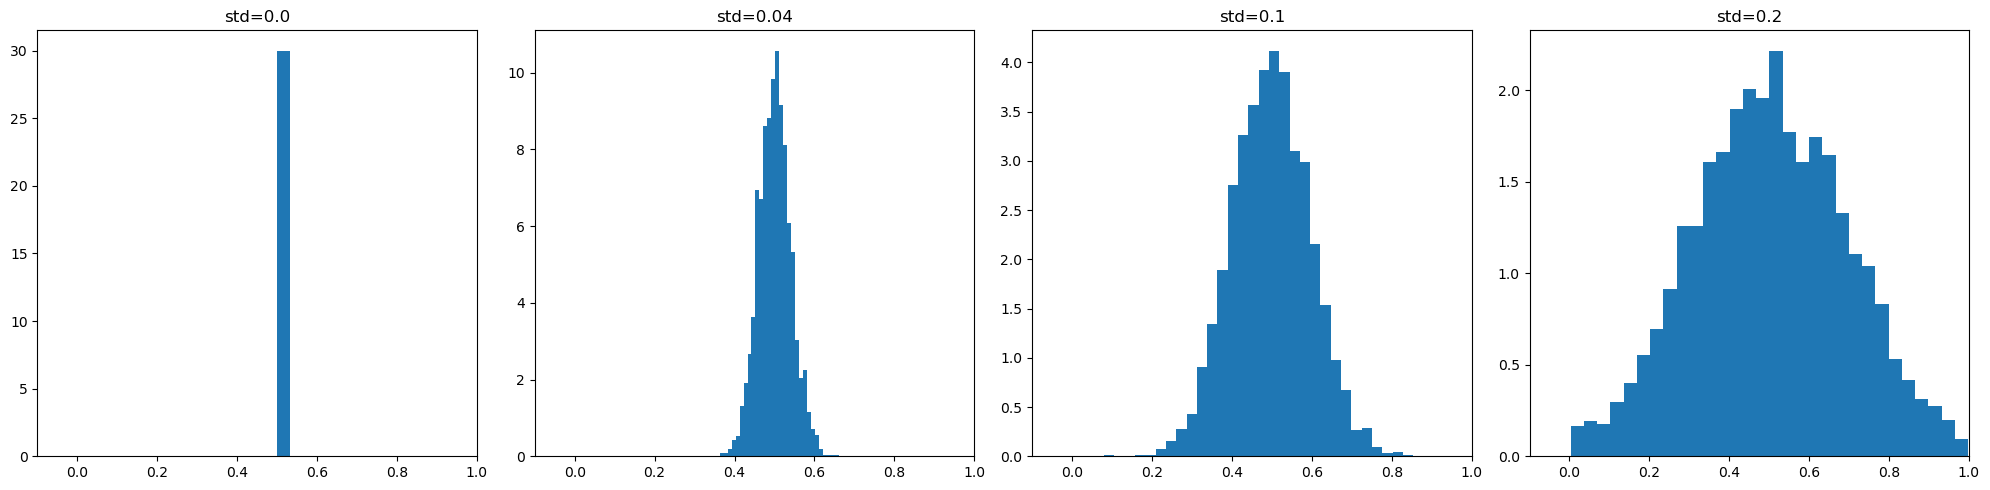

In [150]:
# visualize the distribution of lambda for different values of std
# plt.hist(lambda_mat_nvar[5], bins=30, density =True, label = 'std=0.1')
# plt.xlim(0, 0.4)
# print(np.var(lambda_mat_nvar[5]))

idx_to_plot = [0, 2, 5, 8]
# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot histogram for the selected variance values

for i, idx in enumerate(idx_to_plot):
    axes[i].hist(lambda_mat_nvar[idx], bins=30, density =True, label = f'std={lambda_stds[idx]}')
    axes[i].set_title(f'std={lambda_stds[idx]}')
    axes[i].set_xlim(-0.1, 1.0)




# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

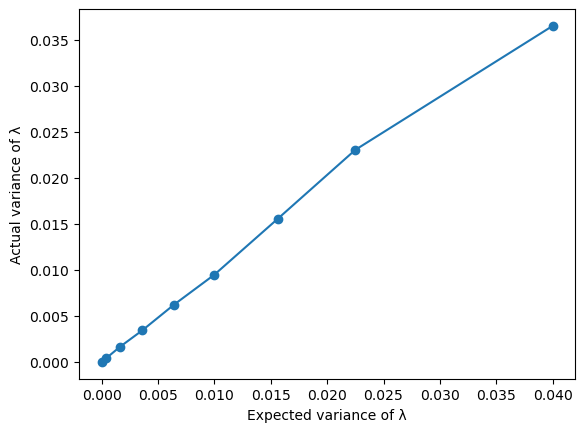

In [151]:
# check actual variance of each distribution
lambda_vars_actual = np.var(lambda_mat_nvar, axis=1)
plt.figure()
plt.plot(lambda_stds**2, lambda_vars_actual, 'o-')
plt.xlabel('Expected variance of λ')

plt.ylabel('Actual variance of λ')
plt.show()


Empirical simulations:


In [157]:
output_c_p_nvar = np.zeros(len(lambda_stds))
output_c_g_nvar = np.zeros(len(lambda_stds))


for idx, std in enumerate(lambda_stds): # iterate over different variance values
    print("processing std: ", std, "\r")
    if std == 0:
        output_c_p_nvar[idx] = SIR_djset(n, edge_ls_p, lambda_mean)
        output_c_g_nvar[idx] = SIR_djset(n, edge_ls_g, lambda_mean)
        print(f"std = {std}, output_p = {output_c_p_nvar[idx]}, output_g = {output_c_g_nvar[idx]}")

    else:
        output_c_p_nvar[idx]= SIR_djset_dir(n, edge_ls_p, lambda_mat_nvar[idx], iter_n=1000)
        output_c_g_nvar[idx]= SIR_djset_dir(n, edge_ls_g, lambda_mat_nvar[idx], iter_n=1000)

        print(f"std = {std}, output_p = {output_c_p_nvar[idx]}, output_g = {output_c_g_nvar[idx]}")
        

processing std:  0.0 
std = 0.0, output_p = 4003.27672646842, output_g = 2849.522487097567
processing std:  0.02 
Edges infected:  19932
Edges infected:  20405
std = 0.02, output_p = 4012.849, output_g = 2797.797
processing std:  0.04 
Edges infected:  20220
Edges infected:  20216
std = 0.04, output_p = 4008.687, output_g = 2830.874
processing std:  0.06 
Edges infected:  20252
Edges infected:  20426
std = 0.06, output_p = 4005.927, output_g = 2842.678
processing std:  0.08 
Edges infected:  19991
Edges infected:  20329
std = 0.08, output_p = 3996.783, output_g = 2781.794
processing std:  0.1 
Edges infected:  20007
Edges infected:  20098
std = 0.1, output_p = 3996.841, output_g = 2766.345
processing std:  0.125 
Edges infected:  20206
Edges infected:  20240
std = 0.125, output_p = 3967.029, output_g = 2827.616
processing std:  0.15 
Edges infected:  19978
Edges infected:  20392
std = 0.15, output_p = 3939.264, output_g = 2797.451
processing std:  0.2 
Edges infected:  20340
Edges infe

In [159]:
print(output_c_p_nvar)
print(output_c_g_nvar)

[4003.27672647 4012.849      4008.687      4005.927      3996.783
 3996.841      3967.029      3939.264      3886.589     ]
[2849.5224871 2797.797     2830.874     2842.678     2781.794
 2766.345     2827.616     2797.451     2749.811    ]


In [131]:
# lambda_stds = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.125, 0.15, 0.2])


# [4003.27672647 4012.849      4008.687      4005.927      3996.783
#  3996.841      3967.029      3939.264      3886.589     ]
# [2849.5224871 2797.797     2830.874     2842.678     2781.794
#  2766.345     2827.616     2797.451     2749.811    ]




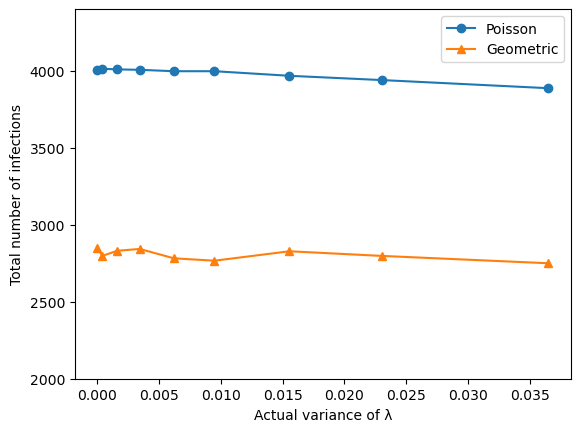

In [162]:
# plot

plt.figure()
plt.plot(lambda_vars_actual, output_c_p_nvar, 'o-', label='Poisson')
plt.plot(lambda_vars_actual, output_c_g_nvar, '^-', label='Geometric')
plt.xlabel("Actual variance of λ")
plt.ylabel("Total number of infections")
plt.ylim([2000, 4400])
plt.legend()



plt.show()

# Mask wearing (Trivial)
Introducing infection weights $w_s$, $w_i$, $w_d$

Let $p_m$ demote percentage of people wearing masks. <br>
Assume a constant $\lambda$ = 0.4. i.e. None distribution

In [ ]:
# # Setup
# n = 10000
# mean = 20
# pm_ary = np.array([0.1, 0.5, 0.8])
# lambda_ary = np.linspace(0.0, 0.3, 31)
# iter_n = 100

In [ ]:
# Run the simulation without mask (original spread)
Nr_ary_nomask = np.zeros(len(lambda_ary))
Nr_covs_nomask = np.zeros(len(lambda_ary))

# Generate one single network and calculate the number of total infections for each lambda
for idx, lambda_ in enumerate(lambda_ary):
    print("processing lambda: ", lambda_)
    edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
    cluster_size = np.zeros(iter_n)
    for itn in range(iter_n):
        print("iter: ", itn, '/', iter_n, end='\r')
        cluster_size[itn] = SIR_djset(n, edge_ls, lambda_)
    mu = np.mean(cluster_size)
    Nr_ary_nomask[idx] = mu
    Nr_covs_nomask[idx] = np.std(cluster_size) / mu

The reduction in infection probability towards a susceptible person wearing masks be $w_s$ = 50%;<br>
The reduction in infection probability from an infectious person wearing masks be $w_i$ = 50%;<br>
The reduction in infection probability for both people wearing masks be $w_b$ = 80%.

In [ ]:
w_s = 0.5 # only susceptible node wearing mask
w_i = 0.5 # only infected node wearing mask
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2
w = np.array([w_s, w_i, w_b])

In [ ]:
def SIR_djset_mask(n, edge_ls, lambda_, pm, w):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0.
    Giving the mask wearing probability for each node."""
    w_s, w_i, w_b = w

    # For a randomly chosen edge, probability of the 3 cases:
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask #FIXME: how to determine if it's the source or sink node?? --> *w_s or *w_i
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) # FIXME: Assume an edge has equal proability of being either direction
    weights = np.array([1.0, w_s, w_i, w_b])

    # For each edge, randomly choose a case based on the probability distribution
    lambdas_weighted = np.random.choice(weights, size=edge_ls.shape[0], p=prob) * lambda_
    # print(lambdas_weighted[:20])



    C = DisjointSet(range(n))
    
    prob_infect = np.random.binomial(1, p=lambdas_weighted) # Randomly assign infection outcome to each edge based on probability weighted lambda_i
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

In [ ]:
# Simulations with mask
Nr_arys_mask = np.zeros((len(pm_ary), len(lambda_ary)))
Nr_covs_mask = np.zeros((len(pm_ary), len(lambda_ary)))


edge_ls = config_graph_edge_ls(n, deg_dist_poisson(n, mean))
for idx1, pm in enumerate(pm_ary):
    print("processing mask wearing proportion: ", pm)


    for idx2, lambda_ in enumerate(lambda_ary):
        print("processing lambda: ", lambda_)
        cluster_size = np.zeros(iter_n)

        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
            cluster_size[itn] = SIR_djset_mask(n, edge_ls, lambda_, pm, w)
        mu = np.mean(cluster_size)
        Nr_arys_mask[idx1,idx2] = mu
        Nr_covs_mask[idx1,idx2] = np.std(cluster_size) / mu

        print(f"mask proportion = {pm}, lambda = {lambda_}, Nr = {mu}")

In [ ]:
# Data store 3:
'''Nr_ary_nomask = [1.00000e+00 1.27000e+00 1.67000e+00 2.42000e+00 4.60000e+00 5.26500e+01
 9.42980e+02 2.27835e+03 4.20314e+03 5.37899e+03 6.71242e+03 7.18865e+03
 7.83659e+03 8.51820e+03 9.06586e+03 9.31269e+03 9.24259e+03 9.43120e+03
 9.50364e+03 9.56494e+03 9.51044e+03 9.74249e+03 9.86891e+03 9.89386e+03
 9.91607e+03 9.93115e+03 9.94320e+03 9.95418e+03 9.96239e+03 9.96867e+03
 9.97464e+03]'''

'''Nr_arys_mask = [[1.00000e+00 1.22000e+00 1.62000e+00 2.52000e+00 3.24000e+00 7.37000e+00
  2.92020e+02 1.48169e+03 2.81346e+03 4.76383e+03 4.94033e+03 6.75778e+03
  7.37751e+03 8.19138e+03 8.25556e+03 8.80741e+03 9.23528e+03 8.88950e+03
  9.07407e+03 9.25002e+03 9.60029e+03 9.65767e+03 9.50270e+03 9.73434e+03
  9.66373e+03 9.88378e+03 9.90311e+03 9.92011e+03 9.93380e+03 9.94576e+03
  9.95413e+03]
 [1.00000e+00 1.11000e+00 1.28000e+00 1.66000e+00 1.80000e+00 2.39000e+00
  2.80000e+00 4.30000e+00 4.64000e+00 1.75300e+01 2.88740e+02 1.23595e+03
  1.99601e+03 2.91367e+03 4.35463e+03 4.50120e+03 5.32222e+03 6.23735e+03
  6.59510e+03 7.07123e+03 7.53019e+03 7.80705e+03 8.03494e+03 8.16645e+03
  8.20185e+03 8.93780e+03 8.84053e+03 8.64102e+03 9.17940e+03 9.23943e+03
  9.48490e+03]
 [1.00000e+00 1.05000e+00 1.11000e+00 1.42000e+00 1.55000e+00 1.26000e+00
  1.80000e+00 1.85000e+00 1.92000e+00 2.70000e+00 2.78000e+00 3.60000e+00
  4.52000e+00 6.87000e+00 8.30000e+00 3.16000e+01 1.34790e+02 3.14960e+02
  8.18040e+02 1.77144e+03 1.81942e+03 2.30825e+03 3.84023e+03 3.85305e+03
  4.66982e+03 4.13071e+03 5.29750e+03 4.93189e+03 5.53855e+03 5.85795e+03
  6.24653e+03]]'''


Theoretical Effect: As if shift mean of lambda by mean[pm_prob] = [0.902, 0.55, 0.328]* lambda

In [ ]:

lambda_ary_eff = np.zeros((len(pm_ary), len(lambda_ary)))
for idx,pm in enumerate(pm_ary):
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask 
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) 
    weights = np.array([1.0, w_s, w_i, w_b])

    lambda_shiftfactor = np.mean(np.dot(prob, weights)) # [0.902, 0.55, 0.328]
    print(f'pm = {pm}:, lambda is effectively factored by {lambda_shiftfactor}')

    lambda_ary_eff[idx] = lambda_ary / lambda_shiftfactor # effective lambda for each mask wearing proportion


In [ ]:
plt.figure()
color_scheme = ['tab:blue', 'tab:orange', 'tab:green']

for idx, pm in enumerate(pm_ary):
    plt.plot(lambda_ary_eff[idx], Nr_ary_nomask, '--', color = color_scheme[idx], label=f"pm={pm}")
    plt.plot(lambda_ary, Nr_arys_mask[idx], 'o-', color = color_scheme[idx])
plt.plot(lambda_ary, Nr_ary_nomask, 'o-', color = 'tab:red', label="no mask")
plt.xlabel("Lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

# Mask wearing

In [ ]:
lambda_means = np.linspace(0.0, 0.3, 31)

In [170]:
# Factoring weights for each edge's infection probability based on mask wearing states for the 2 nodes connected
w_s = 0.6 # only susceptible node wearing mask --> lower by 40%
w_i = 0.4 # only infected node wearing mask --> lower by 60%
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2 --> lower by 80%
w = np.array([w_s, w_i, w_b])

In [184]:
pm_ary = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
lambda_means = np.array([0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0])# different as earlier

mask_states = np.zeros((len(pm_ary), n))

for idx, pm in enumerate(pm_ary):
    # Assign the masking wearing state for each edge based on the mask wearing probability pm
    mask_states[idx] = np.random.binomial(1, p=pm, size=n) # 1 for wearing mask, 0 for not wearing mask
    # shape (len(pm_ary), n)

print(mask_states[:, :20])



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [185]:
output_c_p_mask = np.zeros((len(pm_ary), len(lambda_means)))
output_c_g_mask = np.zeros((len(pm_ary), len(lambda_means)))


for idx, pm in enumerate(pm_ary): # iterate over different mask wearing proportions
    print(f"mask proportion = {pm}\r")

    for idx2, lambda_ in enumerate(lambda_means):
        print(f"processing lambda: {lambda_}\r")
        output_c_p_mask[idx, idx2] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states[idx], w, avg_n=1000)
        output_c_g_mask[idx, idx2] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states[idx], w, avg_n=1000)
        print(f"mask proportion = {pm}, lambda = {lambda_}, output_p = {output_c_p_mask[idx, idx2]}, output_g = {output_c_g_mask[idx, idx2]}")

mask proportion = 0.0
processing lambda: 0.025
Edges infected:  1017
Edges infected:  1036
mask proportion = 0.0, lambda = 0.025, output_p = 1.317, output_g = 1.46
processing lambda: 0.05
Edges infected:  1984
Edges infected:  2034
mask proportion = 0.0, lambda = 0.05, output_p = 2.029, output_g = 4.416
processing lambda: 0.075
Edges infected:  3010
Edges infected:  3050
mask proportion = 0.0, lambda = 0.075, output_p = 3.727, output_g = 228.639
processing lambda: 0.1
Edges infected:  4041
Edges infected:  4062
mask proportion = 0.0, lambda = 0.1, output_p = 32.015, output_g = 566.708
processing lambda: 0.125
Edges infected:  4961
Edges infected:  5120
mask proportion = 0.0, lambda = 0.125, output_p = 407.038, output_g = 864.713
processing lambda: 0.15
Edges infected:  5962
Edges infected:  6170
mask proportion = 0.0, lambda = 0.15, output_p = 1346.572, output_g = 1143.619
processing lambda: 0.2
Edges infected:  8022
Edges infected:  8170
mask proportion = 0.0, lambda = 0.2, output_p =

In [186]:
print(output_c_p_mask)
print(output_c_g_mask)

[[1.317000e+00 2.029000e+00 3.727000e+00 3.201500e+01 4.070380e+02
  1.346572e+03 2.640713e+03 3.220475e+03 3.587268e+03 3.925297e+03
  4.012657e+03 4.052947e+03 4.068000e+03 4.068000e+03]
 [1.230000e+00 1.622000e+00 2.370000e+00 4.989000e+00 2.990400e+01
  4.535770e+02 1.586489e+03 2.286159e+03 2.761786e+03 3.425576e+03
  3.723956e+03 3.825658e+03 3.972090e+03 4.050886e+03]
 [1.135000e+00 1.415000e+00 1.775000e+00 2.340000e+00 3.771000e+00
  1.130800e+01 4.035910e+02 1.019640e+03 1.730571e+03 2.545120e+03
  3.140725e+03 3.468905e+03 3.805516e+03 3.914137e+03]
 [1.107000e+00 1.192000e+00 1.381000e+00 1.648000e+00 2.015000e+00
  2.272000e+00 5.422000e+00 2.554700e+01 2.589310e+02 1.293559e+03
  2.010442e+03 2.585305e+03 3.300074e+03 3.643649e+03]
 [1.071000e+00 1.109000e+00 1.162000e+00 1.264000e+00 1.336000e+00
  1.405000e+00 1.789000e+00 1.913000e+00 2.389000e+00 5.958000e+00
  3.210400e+01 3.635630e+02 1.513926e+03 2.604599e+03]]
[[1.460000e+00 4.416000e+00 2.286390e+02 5.667080e+02 

In [ ]:
# [[1.000000e+00 1.323000e+00 2.228000e+00 5.121000e+00 1.247200e+01
#   1.410078e+03 2.474392e+03 3.240980e+03 3.589040e+03 3.910245e+03
#   4.000606e+03]
#  [1.000000e+00 1.256000e+00 1.613000e+00 2.388000e+00 4.275000e+00
#   2.078650e+02 1.327510e+03 2.126112e+03 2.875537e+03 3.390840e+03
#   3.659081e+03]
#  [1.000000e+00 1.149000e+00 1.446000e+00 1.716000e+00 2.759000e+00
#   1.592300e+01 4.644190e+02 1.175644e+03 1.840067e+03 2.580245e+03
#   3.129961e+03]
#  [1.000000e+00 1.131000e+00 1.256000e+00 1.408000e+00 1.718000e+00
#   2.452000e+00 5.252000e+00 3.311800e+01 4.692290e+02 1.217032e+03
#   2.001788e+03]
#  [1.000000e+00 1.073000e+00 1.108000e+00 1.156000e+00 1.245000e+00
#   1.475000e+00 1.634000e+00 2.097000e+00 2.244000e+00 7.093000e+00
#   1.646500e+01]]
# [[1.000000e+00 1.541000e+00 4.331000e+00 2.088090e+02 5.589770e+02
#   1.227568e+03 1.629626e+03 2.063249e+03 2.191349e+03 2.528956e+03
#   2.849173e+03]
#  [1.000000e+00 1.305000e+00 2.307000e+00 2.401400e+01 2.224290e+02
#   7.710670e+02 1.116024e+03 1.512434e+03 1.749590e+03 2.120517e+03
#   2.423483e+03]
#  [1.000000e+00 1.161000e+00 1.681000e+00 3.639000e+00 4.568700e+01
#   3.693550e+02 6.613960e+02 1.001351e+03 1.279688e+03 1.630770e+03
#   1.901032e+03]
#  [1.000000e+00 1.119000e+00 1.336000e+00 1.561000e+00 2.116000e+00
#   2.706900e+01 2.451390e+02 4.235750e+02 6.933260e+02 1.031396e+03
#   1.401139e+03]
#  [1.000000e+00 1.055000e+00 1.097000e+00 1.213000e+00 1.292000e+00
#   1.731000e+00 2.117000e+00 5.348000e+00 4.625300e+01 2.840320e+02
#   5.460040e+02]]



In [ ]:
[[1.317000e+00 2.029000e+00 3.727000e+00 3.201500e+01 4.070380e+02
  1.346572e+03 2.640713e+03 3.220475e+03 3.587268e+03 3.925297e+03
  4.012657e+03 4.052947e+03 4.068000e+03 4.068000e+03]
 [1.230000e+00 1.622000e+00 2.370000e+00 4.989000e+00 2.990400e+01
  4.535770e+02 1.586489e+03 2.286159e+03 2.761786e+03 3.425576e+03
  3.723956e+03 3.825658e+03 3.972090e+03 4.050886e+03]
 [1.135000e+00 1.415000e+00 1.775000e+00 2.340000e+00 3.771000e+00
  1.130800e+01 4.035910e+02 1.019640e+03 1.730571e+03 2.545120e+03
  3.140725e+03 3.468905e+03 3.805516e+03 3.914137e+03]
 [1.107000e+00 1.192000e+00 1.381000e+00 1.648000e+00 2.015000e+00
  2.272000e+00 5.422000e+00 2.554700e+01 2.589310e+02 1.293559e+03
  2.010442e+03 2.585305e+03 3.300074e+03 3.643649e+03]
 [1.071000e+00 1.109000e+00 1.162000e+00 1.264000e+00 1.336000e+00
  1.405000e+00 1.789000e+00 1.913000e+00 2.389000e+00 5.958000e+00
  3.210400e+01 3.635630e+02 1.513926e+03 2.604599e+03]]
[[1.460000e+00 4.416000e+00 2.286390e+02 5.667080e+02 8.647130e+02
  1.143619e+03 1.699675e+03 1.982028e+03 2.192800e+03 2.548963e+03
  2.840065e+03 2.997904e+03 3.253966e+03 3.402839e+03]
 [1.299000e+00 2.097000e+00 1.560100e+01 2.581260e+02 5.158910e+02
  7.538280e+02 1.205879e+03 1.564690e+03 1.778411e+03 2.114417e+03
  2.474316e+03 2.664483e+03 2.934714e+03 3.158527e+03]
 [1.204000e+00 1.536000e+00 3.520000e+00 5.379500e+01 2.018630e+02
  3.541820e+02 7.079390e+02 1.036441e+03 1.236119e+03 1.604209e+03
  1.983335e+03 2.198822e+03 2.549289e+03 2.827748e+03]
 [1.102000e+00 1.329000e+00 1.863000e+00 3.231000e+00 7.548000e+00
  6.825300e+01 2.130860e+02 4.531720e+02 6.543980e+02 1.030446e+03
  1.439597e+03 1.655538e+03 2.009225e+03 2.334693e+03]
 [1.045000e+00 1.101000e+00 1.173000e+00 1.232000e+00 1.543000e+00
  1.560000e+00 3.243000e+00 5.027000e+00 3.576100e+01 2.606300e+02
  5.864000e+02 7.902870e+02 1.276944e+03 1.596476e+03]]


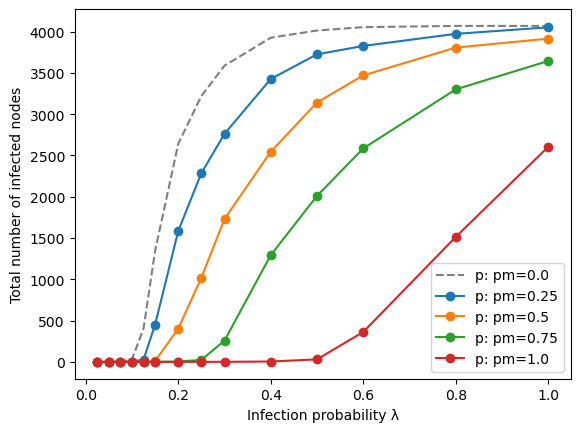

In [187]:
#plot for poisson
plt.figure()

for idx, pm in enumerate(pm_ary):
    if pm == 0.0:
        plt.plot(lambda_means, output_c_p_mask[idx], '--', label=f'p: pm={pm}', color='tab:grey')
    else:
        plt.plot(lambda_means, output_c_p_mask[idx], 'o-', label=f'p: pm={pm}')
plt.xlabel('Infection probability λ')
plt.ylabel('Total number of infected nodes')
plt.legend()
plt.show()

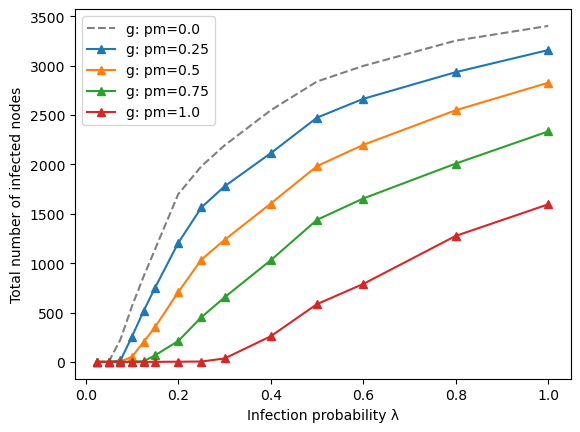

In [188]:
# plot for geometric
plt.figure()
for idx, pm in enumerate(pm_ary):
    if pm == 0.0:
        plt.plot(lambda_means, output_c_g_mask[idx], '--', label=f'g: pm={pm}', color='tab:grey')
    else:
        plt.plot(lambda_means, output_c_g_mask[idx], '^-', label=f'g: pm={pm}')
plt.xlabel('Infection probability λ')
plt.ylabel('Total number of infected nodes')
plt.legend()
plt.show()


## Theoretical change in critical $\lambda$

In [182]:
edge_w_values = np.array([1.0, w_s, w_i, w_b])
edge_w_pmfs = np.zeros((len(pm_ary), 4))

edge_w_means = np.zeros(len(pm_ary))
for idx, pm in enumerate(pm_ary):
    edge_w_pmfs[idx] = np.array([(1-pm)**2, 2*pm*(1-pm), 2*pm*(1-pm), pm**2])
    edge_w_means[idx] = np.dot(edge_w_pmfs[idx], edge_w_values)

lambda_crits_mask_p = lambda_crit_p / edge_w_means
lambda_crits_mask_g = lambda_crit_g / edge_w_means

# Check directed algorithm validity against undirected

In [28]:
mask_states0 = np.zeros(n)

c_p_direc0 = np.zeros(len(lambda_means))
c_g_direc0 = np.zeros(len(lambda_means))

for idx, lambda_ in enumerate(lambda_means):
    print(f"processing lambda: {lambda_}\r")
    c_p_direc0[idx] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states0, w, avg_n=n)
    c_g_direc0[idx] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states0, w, avg_n=n)
    print(f"lambda = {lambda_}, output_p = {c_p_direc0[idx]}, output_g = {c_g_direc0[idx]}")

processing lambda: 0.0
Edges infected:  0
Edges infected:  0
lambda = 0.0, output_p = 1.0, output_g = 1.0
processing lambda: 0.025
Edges infected:  981
Edges infected:  1025
lambda = 0.025, output_p = 1.30572622265913, output_g = 1.482919636274269
processing lambda: 0.05
Edges infected:  2004
Edges infected:  2051
lambda = 0.05, output_p = 1.9329073482428114, output_g = 7.529614155812239
processing lambda: 0.075
Edges infected:  3015
Edges infected:  3067
lambda = 0.075, output_p = 3.891373801916933, output_g = 249.70213811747357
processing lambda: 0.1
Edges infected:  4068
Edges infected:  4039
lambda = 0.1, output_p = 25.520029491275498, output_g = 577.8844925043009
processing lambda: 0.15
Edges infected:  6039
Edges infected:  6176
lambda = 0.15, output_p = 1261.1705578766282, output_g = 1229.4433521749816
processing lambda: 0.2
Edges infected:  8136
Edges infected:  8231
lambda = 0.2, output_p = 2613.1943966576555, output_g = 1666.9184074711231
processing lambda: 0.25
Edges infecte

In [ ]:
print(len(edge_ls_p)) # 20296
print(len(edge_ls_g)) # 20251

In [ ]:
print(c_p_direc0)
print(c_g_direc0)


In [ ]:
# [1.31555665e+00 2.08134677e+00 4.26075203e+00 3.40525928e+01
#  1.43320767e+03 2.66876677e+03 3.22614500e+03 3.57886655e+03
#  3.88810568e+03 4.00625903e+03]
# [1.66650283e+00 6.84000983e+00 1.64889408e+02 6.03161465e+02
#  1.20044237e+03 1.59738412e+03 1.95897665e+03 2.20985598e+03
#  2.57617424e+03 2.80786975e+03]


In [ ]:
# # plot

# colors = ['tab:blue', 'tab:orange', 'tab:green']
# plt.figure()
# for idx, pm in enumerate(pm_ary):
#     plt.plot(lambda_means, output_c_p_mask[idx], 'o-', color = colors[idx], label=f"p:{pm}")
#     plt.plot(lambda_means, output_c_g_mask[idx], '^--', color = colors[idx], label=f"g:{pm}")

# plt.plot(lambda_means, output_c_p_0, 'o-', color = 'tab:red', label="p:0")
# plt.plot(lambda_means, output_c_g_0, '^--', color = 'tab:red', label="g:0")

# plt.xlabel("Mean of λ")
# plt.xscale("log")
# plt.ylabel("Total number of infections")
# plt.legend()
# plt.show()

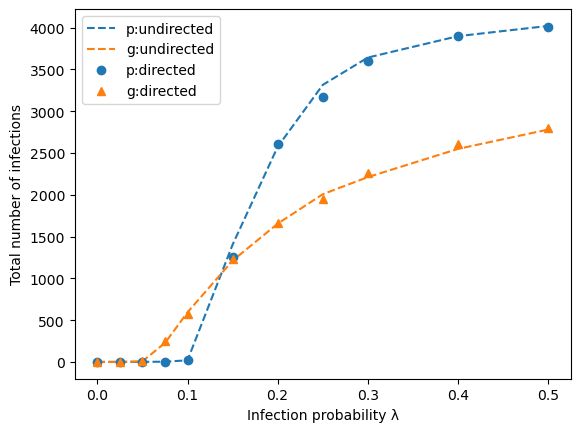

In [46]:
plt.plot(lambda_means, c_p_undirec0, '--', color = 'tab:blue', label='p:undirected')
plt.plot(lambda_means, c_g_undirec0, '--', color = 'tab:orange', label='g:undirected')
plt.plot(lambda_means, c_p_direc0, 'o', color = 'tab:blue', label='p:directed')
plt.plot(lambda_means, c_g_direc0, '^', color = 'tab:orange', label='g:directed')
plt.xlabel("Infection probability λ")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

In [ ]:
lambda_means00 = np.linspace(0.0, 0.025, 11)
mask_states00 = np.zeros(n)
w = np.array([0.6, 0.4, 0.2])

output_c_p_00 = np.zeros(len(lambda_means00))
output_c_g_00 = np.zeros(len(lambda_means00))

for idx, lambda_ in enumerate(lambda_means00):
    print(f"processing lambda: {lambda_}\r")
    output_c_p_00[idx] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states00, w)
    output_c_g_00[idx] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states00, w)
    print(f"lambda = {lambda_}, output_p = {output_c_p_00[idx]}, output_g = {output_c_g_00[idx]}")

In [ ]:
array_5 = [1.0, 109.0, 206.0, 277.0, 389.0, 457.0, 593.0, 637.0, 712.0, 817.0, 933.0]

array_6 = [1.0, 85.0, 170.0, 272.0, 385.0, 438.0, 509.0, 603.0, 657.0, 705.0, 791.0]

In [ ]:
plt.plot(lambda_means, c_p_undirec0, 'o-', color = 'tab:blue', label='p:undirected')
plt.plot(lambda_means, c_g_undirec0, '^--', color = 'tab:blue', label='g:undirected')
plt.plot(lambda_means, c_p_direc0, 'o-', color = 'tab:orange', label='p:directed')
plt.plot(lambda_means, c_g_direc0, '^--', color = 'tab:orange', label='g:directed')

plt.plot(lambda_means00, output_c_p_00, 'o-', color = 'tab:orange', label='p:directed0')
plt.plot(lambda_means00, output_c_g_00, '^--', color = 'tab:orange', label='g:directed0')
plt.xlabel("Infection probability λ")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()